In [1]:
from spriteworld import environment, renderers, sprite, tasks, action_spaces
from spriteworld import factor_distributions as distribs, sprite_generators, gym_wrapper as gymw
import matplotlib.pyplot as plt, copy, numpy as np, os
%matplotlib inline

def viz(obs):
  plt.figure(figsize=(2,2))
  plt.imshow(255 - obs)

In [2]:
IMAGEDIM = 16

In [3]:
factors = distribs.Product([
    distribs.Continuous('x', 0.05, 0.95),
    distribs.Continuous('y', 0.05, 0.95),
    distribs.Continuous('c0', 25, 230),
    distribs.Continuous('c1', 25, 230),
    distribs.Continuous('c2', 25, 230),
    distribs.Discrete('shape', ['square']),
    distribs.Discrete('move_noise', [0.08]),
  ])

sprite_gen = sprite_generators.generate_nonintersecting_sprites(factors, num_sprites=4)
sprite_gen = sprite_generators.sort_by_color(sprite_gen)

In [4]:
random_mtx = (np.random.rand(100, 100) - 0.5)*2.
fn=lambda a: np.dot(random_mtx[:len(a),:len(a)], a)

rndrs = {
      'image':
          renderers.PILRenderer(
              image_size=(IMAGEDIM, IMAGEDIM), anti_aliasing=16),
      'disentangled': renderers.VectorizedPositions(),
      'entangled': renderers.FunctionOfVectorizedPositions(fn=fn),
  }

In [5]:
config = {
    'task': tasks.FindGoalPosition(terminate_distance=0.15),
    'action_space': action_spaces.SelectMove(move_all=True, prevent_intersect=0.1),
    'renderers': rndrs,
    'init_sprites': sprite_gen,
    'max_episode_length': 100,
    'metadata': {
        'name': 'test', #os.path.basename(__file__),
    }
}

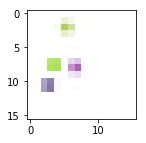

In [6]:
env = environment.Environment(**config)
env = gymw.GymWrapper(env)
viz(env.reset()['image'])

In [7]:
def create_dataset(num_transitions=1000000, reset_prob=0.1, print_every=1000):
  data = []
  s1 = env.reset()
  i = 1
  while len(data) < num_transitions:
    i += 1
    if i % print_every == 0:
      print('.',end='',flush=True)
    a = env.action_space.sample()
    s2, r, _, _ = env.step(a)
    data.append((s1['image'], a, r, s2['image']))
    
    s1 = s2
    if np.random.random() < reset_prob:
      s1 = env.reset()
  return data

In [8]:
d = create_dataset(100)

In [9]:
def visualize_transition(t):
  s1, _, _, s2 = t
  fig, (a1, a2) = plt.subplots(1, 2, figsize=(4, 2))
  a1.imshow(255 - s1)
  a2.imshow(255 - s2)

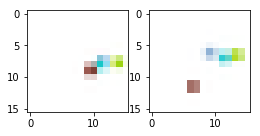

In [10]:
visualize_transition(d[np.random.randint(0,100)])

In [11]:
import pickle

In [12]:
#dataset = create_dataset(60000)
#import pickle
#with open('dataset.pickle', 'wb') as f:
#  pickle.dump(dataset, f)

In [13]:
with open('dataset.pickle', 'rb') as f:
  dataset = pickle.load(f)

# JUST GLOW

In [14]:
import sys
import time
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
sys.path.append("/h/spitis/research/crl/pytglow/")

In [15]:
import argparse
args = argparse.Namespace()
args.batch_size = 1000
args.num_hidden = 64
args.depth = 12
args.n_levels = 3
args.norm = 'actnorm'
args.permutation = 'conv'
args.coupling = 'affine'
args.learntop = False
args.n_bits_x = 8
args.n_epochs = 1000
args.n_warmup = 20
args.lr = 3e-4
args.n_bins = 2 ** args.n_bits_x

args.print_every = 500
args.test_every = 25
args.save_every = 25
args.save_dir='glow/rl_saves'
args.load_dir='glow/rl_saves'

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, utils

from pytglow.invertible_layers import * 
from pytglow.utils import * 

In [17]:
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

### make dataset

In [18]:
import PIL

In [19]:
def postprocess(x):
  x = (1. - x) * 255 + 0.5
  return torch.clamp(x, 0, 255).cpu().numpy().astype(np.uint8).transpose([1,2,0])

tf = transforms.Compose([lambda x: PIL.Image.fromarray(255 - x), transforms.ToTensor()])

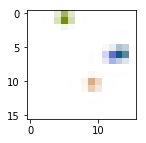

In [20]:
viz(postprocess(tf(dataset[100][0].copy())))

In [21]:
class TransitionsData(torch.utils.data.Dataset):
  
  def __init__(self, data, tf=tf):
    self.data = []
    assert(len(data[0]) == 4) # s, a, r, s'
    self.data = [(tf(t[0].copy()), t[1], t[2], tf(t[3].copy())) for t in data]
      
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    sample = self.data[idx]
    return sample

In [22]:
tr = TransitionsData(dataset[:int(len(dataset)*5/6)])
te = TransitionsData(dataset[int(len(dataset)*5/6):])

train_loader = torch.utils.data.DataLoader(tr, batch_size=args.batch_size, shuffle=True, num_workers=4, drop_last=True)
test_loader  = torch.utils.data.DataLoader(te, batch_size=args.batch_size, shuffle=False, num_workers=4, drop_last=True)

In [23]:
from pytrev.iRevNet import iRevNet

In [77]:
# construct model and ship to GPU
nBlocks = [12, 12]
nStrides = [2,2]
nChannels = [16,64]
model = iRevNet(nBlocks, nStrides, 1, nChannels, init_ds=0, in_shape=(4, IMAGEDIM, IMAGEDIM)).cuda()
print(model)
print("number of model parameters:", sum([np.prod(p.size()) for p in model.parameters()]))


 == Building iRevNet 73 == 
iRevNet(
  (init_psi): psi()
  (stack): ModuleList(
    (0): irevnet_block(
      (inj_pad): injective_pad()
      (psi): psi()
      (bottleneck_block): Sequential(
        (0): Conv2d(2, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): Dropout(p=0.0)
        (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): ReLU(inplace)
        (7): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
    (1): irevnet_block(
      (inj_pad): injective_pad()
      (psi): psi()
      (bottleneck_block): Sequential(
        (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace)
        (2): Conv2d(16,

In [78]:
# set up the optimizer
opt = optim.Adam(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=45, gamma=0.1)
start_epoch = 0
model = nn.DataParallel(model, device_ids=(0,)).cuda()

In [79]:
def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1) # (x_size, 1, dim)
    y = y.unsqueeze(0) # (1, y_size, dim)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2)/float(dim)
    return torch.exp(-kernel_input) # (x_size, y_size)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd

In [80]:
b = next(iter(train_loader))

In [81]:
x, _, _, _ = b

In [76]:
_, z = model(F.pad(x, (0,0,0,0,0,))

RuntimeError: Given groups=1, weight of size [4, 1, 3, 3], expected input[1000, 2, 16, 16] to have 1 channels, but got 2 channels instead

In [69]:
z.shape

torch.Size([1000, 128, 4, 4])

In [70]:
128*4*4

2048

In [ ]:
# training loop
# ------------------------------------------------------------------------------
for epoch in range(start_epoch, args.n_epochs):
  print('epoch %s' % epoch)
  t = time.time()
  model.train()
  num_batches = len(train_loader)
  for i, (img, _, _, _) in enumerate(train_loader):
    # if i > 3 : break

    img = img.cuda() 
    _, z = model(img)
    true_samples = torch.randn(args.batch_size, z.shape)

    # Generative loss
    nobj = torch.mean(nll)

    opt.zero_grad()
    nobj.backward()
    torch.nn.utils.clip_grad_value_(model.parameters(), 5)
    torch.nn.utils.clip_grad_norm_(model.parameters(), 100)
    opt.step()
    avg_train_bits_x += nobj.item()

    # update learning rate
    new_lr = float(args.lr * min(1., (i + epoch * num_batches) / (args.n_warmup * num_batches)))
    for pg in opt.param_groups: pg['lr'] = new_lr

    if (i + 1) % args.print_every == 0: 
      print('avg train bits per pixel {:.4f}'.format(avg_train_bits_x / args.print_every))
      avg_train_bits_x = 0.
      sample = (model.module.sample())
      grid = utils.make_grid(sample)
      utils.save_image(grid, './glow/rl_samples/rl_Test_{}_{}.png'.format(epoch, i // args.print_every))
    print('.',end='',flush=True)
  print('')
  print('training epoch took {:.4f}'.format(time.time() - t))

  # test loop
  # --------------------------------------------------------------------------
  if (epoch + 1) % args.test_every == 0:
    model.eval()
    avg_test_bits_x = 0.
    with torch.no_grad():
      for i, (img, _, _, _) in enumerate(test_loader): 
        # if i > 10 : break
        img = img.cuda() 
        objective = torch.zeros_like(img[:, 0, 0, 0])

        # discretizing cost 
        objective += float(-np.log(args.n_bins) * np.prod(img.shape[1:]))

        # log_det_jacobian cost (and some prior from Split OP)
        z, objective = model(img, objective)
        last_img = img

        nll = (-objective) / float(np.log(2.) * np.prod(img.shape[1:]))

        # Generative loss
        nobj = torch.mean(nll)
        avg_test_bits_x += nobj.item()

      print('avg test bits per pixel {:.4f}'.format(avg_test_bits_x / i))

      sample = (model.module.sample())
      utils.save_image(sample, './glow/rl_samples/rl_Test_{}.png'.format(epoch))

      # reconstruct
      x_hat = (model.module.reverse_(z, objective)[0])
      utils.save_image(x_hat, './glow/rl_samples/rl_Test_Recon{}.png'.format(epoch))

      utils.save_image((last_img), './glow/rl_samples/rl_Test_Target.png')



  if (epoch + 1) % args.save_every == 0: 
    save_session(model, opt, args, epoch)

In [25]:
# construct model and ship to GPU
# model = Glow_((args.batch_size, 3, IMAGEDIM, IMAGEDIM), args).cuda()
# print(model)
# print("number of model parameters:", sum([np.prod(p.size()) for p in model.parameters()]))

In [26]:
# set up the optimizer
opt = optim.Adam(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=45, gamma=0.1)

In [109]:
# data dependant init
init_loader = torch.utils.data.DataLoader(tr, batch_size=args.batch_size, shuffle=True, num_workers=1, drop_last=True)

with torch.no_grad():
  model.eval()
  for (img, _, _, _) in iter(init_loader):
    img = img.cuda()
    objective = torch.zeros_like(img[:, 0, 0, 0])
    _ = model(img, objective)
    break

In [110]:
start_epoch = 0
model = nn.DataParallel(model).cuda()

# load trained model if necessary (must be done after DataParallel)
#if args.load_dir is not None: 
#    model, opt, start_epoch = load_session(model, opt, args)

In [111]:
# training loop
# ------------------------------------------------------------------------------
for epoch in range(start_epoch, args.n_epochs):
  print('epoch %s' % epoch)
  t = time.time()
  model.train()
  avg_train_bits_x = 0.
  num_batches = len(train_loader)
  for i, (img, _, _, _) in enumerate(train_loader):
    # if i > 3 : break

    img = img.cuda() 
    objective = torch.zeros_like(img[:, 0, 0, 0])

    # discretizing cost 
    objective += float(-np.log(args.n_bins) * np.prod(img.shape[1:]))

    # log_det_jacobian cost (and some prior from Split OP)
    z, objective = model(img, objective)

    nll = (-objective) / float(np.log(2.) * np.prod(img.shape[1:]))

    # Generative loss
    nobj = torch.mean(nll)

    opt.zero_grad()
    nobj.backward()
    torch.nn.utils.clip_grad_value_(model.parameters(), 5)
    torch.nn.utils.clip_grad_norm_(model.parameters(), 100)
    opt.step()
    avg_train_bits_x += nobj.item()

    # update learning rate
    new_lr = float(args.lr * min(1., (i + epoch * num_batches) / (args.n_warmup * num_batches)))
    for pg in opt.param_groups: pg['lr'] = new_lr

    if (i + 1) % args.print_every == 0: 
      print('avg train bits per pixel {:.4f}'.format(avg_train_bits_x / args.print_every))
      avg_train_bits_x = 0.
      sample = (model.module.sample())
      grid = utils.make_grid(sample)
      utils.save_image(grid, './glow/rl_samples/rl_Test_{}_{}.png'.format(epoch, i // args.print_every))
    print('.',end='',flush=True)
  print('')
  print('training epoch took {:.4f}'.format(time.time() - t))

  # test loop
  # --------------------------------------------------------------------------
  if (epoch + 1) % args.test_every == 0:
    model.eval()
    avg_test_bits_x = 0.
    with torch.no_grad():
      for i, (img, _, _, _) in enumerate(test_loader): 
        # if i > 10 : break
        img = img.cuda() 
        objective = torch.zeros_like(img[:, 0, 0, 0])

        # discretizing cost 
        objective += float(-np.log(args.n_bins) * np.prod(img.shape[1:]))

        # log_det_jacobian cost (and some prior from Split OP)
        z, objective = model(img, objective)
        last_img = img

        nll = (-objective) / float(np.log(2.) * np.prod(img.shape[1:]))

        # Generative loss
        nobj = torch.mean(nll)
        avg_test_bits_x += nobj.item()

      print('avg test bits per pixel {:.4f}'.format(avg_test_bits_x / i))

      sample = (model.module.sample())
      utils.save_image(sample, './glow/rl_samples/rl_Test_{}.png'.format(epoch))

      # reconstruct
      x_hat = (model.module.reverse_(z, objective)[0])
      utils.save_image(x_hat, './glow/rl_samples/rl_Test_Recon{}.png'.format(epoch))

      utils.save_image((last_img), './glow/rl_samples/rl_Test_Target.png')



  if (epoch + 1) % args.save_every == 0: 
    save_session(model, opt, args, epoch)

epoch 0
..................................................
training epoch took 23.6813
epoch 1
..................................................
training epoch took 23.6226
epoch 2
..................................................
training epoch took 23.6804
epoch 3
..................................................
training epoch took 23.6950
epoch 4
..................................................
training epoch took 23.7230
epoch 5
..................................................
training epoch took 23.7687
epoch 6
..................................................
training epoch took 22.8972
epoch 7
..................................................
training epoch took 23.8966
epoch 8
..................................................
training epoch took 23.7964
epoch 9
..................................................
training epoch took 23.8329
epoch 10
..................................................
training epoch took 23.3122
epoch 11
.................................

..................................................
training epoch took 24.1063
epoch 182
..................................................
training epoch took 24.1228
epoch 183
..................................................
training epoch took 24.2095
epoch 184
..................................................
training epoch took 24.0773
epoch 185
..................................................
training epoch took 24.1440
epoch 186
..................................................
training epoch took 23.7716
epoch 187
..................................................
training epoch took 24.1767
epoch 188
..................................................
training epoch took 22.9028
epoch 189
..................................................
training epoch took 23.1986
epoch 190
..................................................
training epoch took 23.9354
epoch 191
..................................................
training epoch took 24.2519
epoch 192
.....................

..................................................
training epoch took 24.3187
epoch 361
..................................................
training epoch took 24.3237
epoch 362
..................................................
training epoch took 24.4297
epoch 363
..................................................
training epoch took 24.3556
epoch 364
..................................................
training epoch took 24.3670
epoch 365
..................................................
training epoch took 23.5211
epoch 366
..................................................
training epoch took 24.3819
epoch 367
..................................................
training epoch took 24.3569
epoch 368
..................................................
training epoch took 24.2853
epoch 369
..................................................
training epoch took 24.4117
epoch 370
..................................................
training epoch took 24.3028
epoch 371
.....................

Successfully saved model
epoch 450
..................................................
training epoch took 24.4918
epoch 451
..................................................
training epoch took 24.3377
epoch 452
..................................................
training epoch took 23.2048
epoch 453
..................................................
training epoch took 24.3015
epoch 454
..................................................
training epoch took 24.5050
epoch 455
..................................................
training epoch took 24.2992
epoch 456
..................................................
training epoch took 24.3980
epoch 457
..................................................
training epoch took 24.3456
epoch 458
..................................................
training epoch took 24.2220
epoch 459
..................................................
training epoch took 24.4176
epoch 460
..................................................
training epoch took 24.4

..................................................
training epoch took 24.4107
epoch 541
..................................................
training epoch took 24.3913
epoch 542
..................................................
training epoch took 24.4417
epoch 543
..................................................
training epoch took 24.5275
epoch 544
..................................................
training epoch took 23.5149
epoch 545
..................................................
training epoch took 24.4539
epoch 546
..................................................
training epoch took 24.4503
epoch 547
..................................................
training epoch took 24.0472
epoch 548
..................................................
training epoch took 24.5977
epoch 549
..................................................
training epoch took 24.3349
avg test bits per pixel -0.8969
Successfully saved model
epoch 550
..................................................
tr

..................................................
training epoch took 23.8438
epoch 720
..................................................
training epoch took 24.0090
epoch 721
..................................................
training epoch took 23.9825
epoch 722
..................................................
training epoch took 24.0322
epoch 723
..................................................
training epoch took 22.9929
epoch 724
..................................................
training epoch took 23.9126
avg test bits per pixel -0.9702
Successfully saved model
epoch 725
..................................................
training epoch took 23.9326
epoch 726
..................................................
training epoch took 23.9665
epoch 727
..................................................
training epoch took 24.0361
epoch 728
..................................................
training epoch took 23.9295
epoch 729
..................................................
tr

..................................................
training epoch took 24.0344
epoch 899
..................................................
training epoch took 23.9889
avg test bits per pixel -1.0964
Successfully saved model
epoch 900
..................................................
training epoch took 24.0345
epoch 901
..................................................
training epoch took 23.9794
epoch 902
..................................................
training epoch took 23.9888
epoch 903
..................................................
training epoch took 24.0949
epoch 904
..................................................
training epoch took 24.0402
epoch 905
..................................................
training epoch took 23.6249
epoch 906
..................................................
training epoch took 23.9944
epoch 907
..................................................
training epoch took 24.0027
epoch 908
..................................................
tr

In [ ]:
viz(postprocess(last_img[0]))

In [119]:
utils.save_image((1. - last_img), './glow/rl_samples/rl_Test_Target.png', padding=1)